In [1]:
import torch
import diffusers
import matplotlib.pyplot as plt

## Modelos de Difusión.
Basados en eliminar ruido de una imágen.
Si se alimentan con ruido aleatgorio, genera imágenes nuevas.

Su principal fortaleza es el Refinamiento iterativo

In [2]:
image_pipe = diffusers.DDPMPipeline.from_pretrained("google/ddpm-celebahq-256", use_safetensors=False).to("cuda")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
image_pipe().images[0]

## Vistazo más profundo
Usando un pipeline ya creado no permite conocer bien el funcionamiento del modelo
Hagamos una prueba a mano

In [77]:
image = torch.rand(4,3,256,256).cuda()  # Lote de 4 imágenes de 3 canales de 256x256 px

# Especificamos el numero de iteraciones de la generación:
image_pipe.scheduler.set_timesteps(num_inference_steps=150)

In [22]:
import numpy as np
def normalizar_a_255_general(array_numpy):
    """
    Normaliza un array de NumPy a escala de grises (rango [0, 255], dtype uint8)
    detectando automáticamente los valores mínimo y máximo del array de entrada.

    Args:
        array_numpy: El array de NumPy de entrada.

    Returns:
        Un array de NumPy normalizado en el rango [0, 255] y tipo de dato uint8.
        Si todos los valores de entrada son iguales, devuelve un array lleno de 127 (gris medio).
    """
    min_valor = np.min(array_numpy) # Encontrar el valor mínimo en el array
    max_valor = np.max(array_numpy) # Encontrar el valor máximo en el array

    # Caso especial: Si el valor mínimo y máximo son iguales, evitar división por cero y devolver un array gris medio
    if max_valor == min_valor:
        return np.full_like(array_numpy, 127, dtype=np.uint8) # Devolver array lleno de gris medio (valor 127)

    # Normalización general: Mapear el rango [min_valor, max_valor] a [0, 255]
    array_normalizado = (array_numpy - min_valor) / (max_valor - min_valor) * 255
    return array_normalizado.astype(np.uint8) # Convertir a uint8

In [ ]:
# Bucle de generación
for i, t in enumerate(image_pipe.scheduler.timesteps):

    with torch.inference_mode():                        # Iteramos una vez. No estamos entrenando
        noise_pred = image_pipe.unet(image,t)["sample"]

    # Calculamos la actualización de nuestras muestras aleatorias
    scheduler_output = image_pipe.scheduler.step(noise_pred, t, image)

    # volvemos a utilizar los datos como generados como entrada de la red
    image = scheduler_output.prev_sample

    # print("Step: ",i)
    if (i%10 == 0) or (i == len(image_pipe.scheduler.timesteps)-1):
        # img_list = [torch.Tensor(normalizar_a_255_general(x.cpu().numpy())).int() for x in scheduler_output.prev_sample] + [torch.Tensor(normalizar_a_255_general(x.cpu().numpy())).int() for x in scheduler_output.pred_original_sample]
        img_list = [x for x in image] + [x for x in scheduler_output.pred_original_sample]
        

        full_img = torch.cat(img_list,dim=2)
        plt.imshow(full_img.cpu().movedim(0,-1))
        plt.pause(0.1)



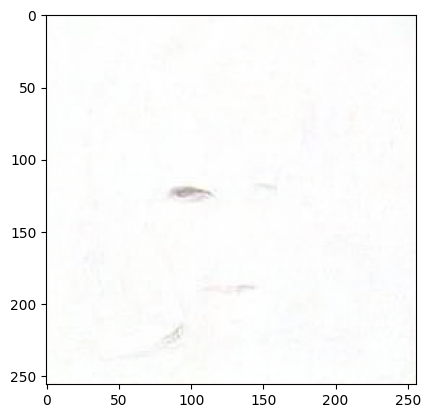

In [73]:
plt.imshow(image.cpu()[0].movedim(0,-1))

In [5]:
with torch.inference_mode():
    data = image_pipe.unet(image,0)

In [6]:
scheduler_output = image_pipe.scheduler.step(data["sample"], 0, image)

In [ ]:
# data["sample"][0]
len([x for x in image])

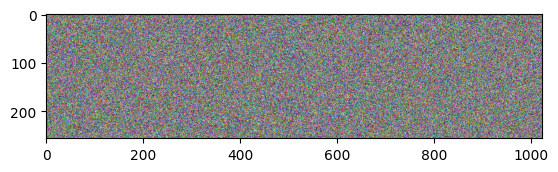

In [29]:
a = [x for x in (scheduler_output["pred_original_sample"] -0.5)*8]

for i,img in enumerate(a):
    a[i] = torch.Tensor(normalizar_a_255_general(img.cpu().numpy())).int()

a = torch.cat(a,dim=2)
plt.imshow(a.cpu().movedim(0,-1))


In [15]:
a.cpu().numpy()

array([[[0.5386705 , 0.7736771 , 0.5985316 , ..., 0.3805255 ,
         0.16259061, 0.07624199],
        [0.8617815 , 0.31688786, 0.89199376, ..., 0.5954741 ,
         0.8572888 , 0.30170846],
        [0.37290388, 0.1160769 , 0.71178836, ..., 0.92135143,
         0.6717761 , 0.8276466 ],
        ...,
        [0.32963163, 0.46163246, 0.6714133 , ..., 0.07656005,
         0.81158763, 0.9069386 ],
        [0.5506296 , 0.20837584, 0.14664261, ..., 0.6680876 ,
         0.1627149 , 0.43235543],
        [0.14154492, 0.30449215, 0.50519097, ..., 0.46880093,
         0.22412062, 0.49502647]],

       [[0.22926576, 0.7029155 , 0.72096163, ..., 0.8079567 ,
         0.34741142, 0.6494625 ],
        [0.5033006 , 0.8280523 , 0.81211054, ..., 0.20767683,
         0.9369012 , 0.935048  ],
        [0.50697803, 0.20895295, 0.6342095 , ..., 0.8176202 ,
         0.78687876, 0.9156403 ],
        ...,
        [0.26180148, 0.20651847, 0.28519326, ..., 0.24567924,
         0.88948625, 0.3969654 ],
        [0.5